In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
import os
from matplotlib.patches import Rectangle
from lxml import etree
from sklearn.preprocessing import LabelBinarizer
# Enable Matplotlib backend for displaying static images
%matplotlib inline

In [2]:
# --- Training history persistence & plotting utilities ---
from pathlib import Path
import json, os
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

# --- Run Config ---
# Set to True to force retraining even if a saved .keras model exists.
#FORCE_RETRAIN = True
FORCE_RETRAIN = False

# --- VGG16 ---
VGG_MODEL_PATH = Path("data/model/vgg16/vgg16_model.keras")
VGG_MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
VGG_META_PATH  = VGG_MODEL_PATH.with_suffix(".meta.json")
VGG_HISTORY_JSON = Path("data/model/vgg16/vgg16_history.json")
VGG_HISTORY_CSV  = VGG_HISTORY_JSON.with_suffix(".csv")

# --- Xception ---
XCP_MODEL_PATH = Path("data/model/xception/xception_model.keras")
XCP_MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
XCP_META_PATH  = XCP_MODEL_PATH.with_suffix(".meta.json")
XCP_HISTORY_JSON = Path("data/model/xception/xception_history.json")
XCP_HISTORY_CSV  = XCP_HISTORY_JSON.with_suffix(".csv")

# --- Inception ---
ICP_MODEL_PATH = Path("data/model/inception/inception_model.keras")
ICP_MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
ICP_META_PATH  = ICP_MODEL_PATH.with_suffix(".meta.json")
ICP_HISTORY_JSON = Path("data/model/inception/inception_history.json")
ICP_HISTORY_CSV  = ICP_HISTORY_JSON.with_suffix(".csv")

# Config flags
META_STRICT = False           # If True, require exact match on ALL keys
CHECK_DATASET_SIG = False     # If True, enforce dataset signature equality

In [3]:
def make_current_meta(model_arch: str, image_size):
    """
    Build the CURRENT_META dict for metadata checks.
    - model_arch: e.g. "VGG16", "Xception"
    - image_size: e.g. (224, 224) or (299, 299)
    """
    # Always refresh these live (in case folders changed)
    class_names = get_class_names_from_dirs()
    return {
        "image_size": tuple(image_size),          # normalize to tuple
        "class_names": class_names,
        "num_classes": len(class_names),
        "preprocessing": "rescale(1/255)",        # keep in sync with your pipeline
        "model_arch": model_arch,
        "dataset_sig": dataset_signature(),
    }

# Save the training history so we can reload it once training is done.
def save_history(history, *, json_path=None, csv_path=None):
    """Persist Keras History to JSON and CSV for later reuse."""
    if history is None or not hasattr(history, "history"):
        return
    jp = Path(json_path) if json_path else HISTORY_JSON
    cp = Path(csv_path)  if csv_path  else HISTORY_CSV
    jp.parent.mkdir(parents=True, exist_ok=True)
    # JSON
    payload = {**history.history, "epoch": list(history.epoch)}
    with open(jp, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, sort_keys=True)
    # CSV
    df = pd.DataFrame(payload)
    df.to_csv(cp, index=False)

# Return the training history as a Pandas DataFrame extracted from either a json or csv file.
def load_history_df(*, json_path=None, csv_path=None):
    """Load previously saved history as a pandas DataFrame, if available."""
    jp = Path(json_path) if json_path else HISTORY_JSON
    cp = Path(csv_path)  if csv_path  else HISTORY_CSV
    if jp.exists():
        with open(jp, "r", encoding="utf-8") as f:
            data = json.load(f)
        return pd.DataFrame(data)
    if cp.exists():
        return pd.read_csv(cp)
    return None
    
# Plot the training history
def plot_history_df(df):
    """Plot common metrics from a history DataFrame, if present."""
    if df is None or "epoch" not in df.columns:
        print("No saved training history available to plot.")
        return
    # Loss
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if "loss" in df.columns:
        plt.plot(df["epoch"], df["loss"], label="train loss")
    if "val_loss" in df.columns:
        plt.plot(df["epoch"], df["val_loss"], label="val loss")
    plt.legend()
   
    # Example: class accuracy if present
    if "val_class_acc" in df.columns:
        plt.figure()
        plt.xlabel("Epoch")
        plt.ylabel("Validation Accuracy (Class)")
        plt.plot(df["epoch"], df["val_class_acc"], label="val_class_acc")
        plt.legend()
        plt.show()

    # Example: MAEs if present
    for col in ["val_xmin_mae","val_ymin_mae","val_xmax_mae","val_ymax_mae"]:
        if col not in df.columns:
            return

    plt.figure()                                      
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")               
    plt.plot(df["epoch"], df["val_xmin_mae"], label = "xmin_MAE")
    plt.plot(df["epoch"], df["val_ymin_mae"], label = "ymin_MAE")
    plt.plot(df["epoch"], df["val_xmax_mae"], label = "xmax_MAE")
    plt.plot(df["epoch"], df["val_ymax_mae"], label = "ymax_MAE")
    plt.legend() 

    plt.show()


In [4]:
# Subfolders for the class labels
os.listdir("data/images/images")

['crease',
 'crescent_gap',
 'inclusion',
 'oil_spot',
 'punching_hole',
 'rolled_pit',
 'silk_spot',
 'waist folding',
 'water_spot',
 'welding_line']

In [5]:
# Annotations of the class labels
os.listdir("data/label/label")[:5]

['img_01_3402617700_00001.xml',
 'img_01_3402617700_01009.xml',
 'img_01_3436789500_00004.xml',
 'img_01_3436814600_00259.xml',
 'img_01_3436815300_00473.xml']

In [6]:
# Read all the images and count the number of image paths in the training subfolders
image_path = glob.glob("data/images/images/*/*.jpg")
# Normalize slashes to one format first
image_path = [p.replace('\\', '/') for p in image_path]

In [7]:
len(image_path)

2306

In [8]:
# Read all the annotation files and count the number of annotations in the training label folder
xmls_path = glob.glob("data/label/label/*.xml")
# Normalize slashes to one format first
xmls_path = [p.replace('\\', '/') for p in xmls_path]

In [9]:
len(xmls_path)

2280

In [10]:
xmls_path[:5]

['data/label/label/img_01_3402617700_00001.xml',
 'data/label/label/img_01_3402617700_01009.xml',
 'data/label/label/img_01_3436789500_00004.xml',
 'data/label/label/img_01_3436814600_00259.xml',
 'data/label/label/img_01_3436815300_00473.xml']

In [11]:
# Sort the annotation and image files in ascending order
# The filenames are identical except for the extension.  This allows for a correct mapping of image to annotation by index.
xmls_path.sort(key = lambda x:x.split("/")[-1].split(".xml")[0])
image_path.sort(key = lambda x:x.split("/")[-1].split(".jpg")[0])

In [12]:
xmls_path[:5]

['data/label/label/img_01_3402617700_00001.xml',
 'data/label/label/img_01_3402617700_01009.xml',
 'data/label/label/img_01_3436789500_00004.xml',
 'data/label/label/img_01_3436814600_00259.xml',
 'data/label/label/img_01_3436815300_00473.xml']

In [13]:
image_path[:5]

['data/images/images/crescent_gap/img_01_3402617700_00001.jpg',
 'data/images/images/crescent_gap/img_01_3402617700_01009.jpg',
 'data/images/images/crease/img_01_3436789500_00004.jpg',
 'data/images/images/silk_spot/img_01_3436814600_00259.jpg',
 'data/images/images/silk_spot/img_01_3436815300_00473.jpg']

In [14]:
# Extract the annotation filename without extension
xmls_train = [path.split("/")[-1].split(".")[0] for path in xmls_path]

In [15]:
xmls_train[:5]

['img_01_3402617700_00001',
 'img_01_3402617700_01009',
 'img_01_3436789500_00004',
 'img_01_3436814600_00259',
 'img_01_3436815300_00473']

In [16]:
# Retrieve the image filename that have a corresponding annotation file. Not all images have annotations (defects)
# This will be the training set of images.
imgs_train = [img for img in image_path if (img.split("/")[-1].split)(".jpg")[0] in xmls_train]
imgs_train[:5]

['data/images/images/crescent_gap/img_01_3402617700_00001.jpg',
 'data/images/images/crescent_gap/img_01_3402617700_01009.jpg',
 'data/images/images/crease/img_01_3436789500_00004.jpg',
 'data/images/images/silk_spot/img_01_3436814600_00259.jpg',
 'data/images/images/silk_spot/img_01_3436815300_00473.jpg']

In [17]:
# Ensure equal counts of training images with the annotations
len(imgs_train),len(xmls_train)

(2280, 2280)

In [18]:
#########################
# SET UP THE DATA FRAME #
#########################

In [19]:
# Extract class label from the path of each image file
labels = [label.split("/")[-2] for label in imgs_train]
labels[:15]

['crescent_gap',
 'crescent_gap',
 'crease',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'crescent_gap',
 'crescent_gap',
 'crescent_gap',
 'crescent_gap',
 'crescent_gap',
 'crescent_gap',
 'crescent_gap']

In [20]:
# Convert the labels into a Pandas DataFrame for the class labels and call them Defect Types
dataFrame = pd.DataFrame(labels, columns = ["Defect Type"])
dataFrame

,Defect Type
0,crescent_gap
1,crescent_gap
2,crease
3,silk_spot
4,silk_spot
...,...
2275,silk_spot
2276,silk_spot
2277,silk_spot
2278,silk_spot


In [21]:
# Obtain training labels without duplication
Class = dataFrame["Defect Type"].unique()

In [22]:
print(Class)

['crescent_gap' 'crease' 'silk_spot' 'water_spot' 'welding_line'
 'inclusion' 'oil_spot' 'waist folding' 'rolled_pit' 'punching_hole']


In [23]:
# Pair each element in Class with a corresponding number starting from 1
zip_result = list(zip(Class, range(1, len(Class) + 1)))
print(zip_result)

[('crescent_gap', 1), ('crease', 2), ('silk_spot', 3), ('water_spot', 4), ('welding_line', 5), ('inclusion', 6), ('oil_spot', 7), ('waist folding', 8), ('rolled_pit', 9), ('punching_hole', 10)]


In [24]:
# Transform the tuple into a map of defect type to it's numerical reference (defect class index)
Class_dict = dict(zip_result)
Class_dict

{'crescent_gap': 1,
 'crease': 2,
 'silk_spot': 3,
 'water_spot': 4,
 'welding_line': 5,
 'inclusion': 6,
 'oil_spot': 7,
 'waist folding': 8,
 'rolled_pit': 9,
 'punching_hole': 10}

In [25]:
# Create a new column called "Class" in the data frome and store the corresponding defect index
dataFrame["Class"] = dataFrame["Defect Type"].apply(lambda x: Class_dict[x])
dataFrame

,Defect Type,Class
0,crescent_gap,1
1,crescent_gap,1
2,crease,2
3,silk_spot,3
4,silk_spot,3
...,...,...
2275,silk_spot,3
2276,silk_spot,3
2277,silk_spot,3
2278,silk_spot,3


In [26]:
# Convert the class dictionary into binary vectors for easier processing.
# Set up a One-hot encoding to represent the classification types.  A one-hot encoded vector is a way of representing categorical values as binary vectors
# where exactly one element is 1 (the "hot" one) and all others are 0.  Each  is assigned a binary vector of 10 with the bit for the
# specific defect type turned "on".
lb = LabelBinarizer()
# Fit it to the class dictionary
lb.fit(list(Class_dict.values()))
# Convert multi-class labels to binary labels (belong or does not belong) to the labels
binary_labels = lb.transform(dataFrame["Class"])
binary_labels[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [27]:
binary_labels.shape

(2280, 10)

In [28]:
# Create some new columns corresponding to the class index
y_bin_labels = [] 
for i in range(binary_labels.shape[1]):
    y_bin_labels.append("Class" + str(i))
    # Add the columns to the data frame.
    dataFrame["Class" + str(i + 1)] = binary_labels[:, i]

In [29]:
y_bin_labels[:10]

['Class0',
 'Class1',
 'Class2',
 'Class3',
 'Class4',
 'Class5',
 'Class6',
 'Class7',
 'Class8',
 'Class9']

In [30]:
dataFrame

,Defect Type,Class,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,crescent_gap,1,1,0,0,0,0,0,0,0,0,0
1,crescent_gap,1,1,0,0,0,0,0,0,0,0,0
2,crease,2,0,1,0,0,0,0,0,0,0,0
3,silk_spot,3,0,0,1,0,0,0,0,0,0,0
4,silk_spot,3,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2275,silk_spot,3,0,0,1,0,0,0,0,0,0,0
2276,silk_spot,3,0,0,1,0,0,0,0,0,0,0
2277,silk_spot,3,0,0,1,0,0,0,0,0,0,0
2278,silk_spot,3,0,0,1,0,0,0,0,0,0,0


In [31]:
# Above you see the english name of the classification plus both the associated numeric (Class) and binary classfications.

In [32]:
# Drop the English and numerical classfication columns because the machine doesn't need them.
dataFrame.drop("Class", axis = 1, inplace = True)
dataFrame.drop("Defect Type", axis = 1, inplace = True)

In [33]:
# Display the current data frame
dataFrame

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2275,0,0,1,0,0,0,0,0,0,0
2276,0,0,1,0,0,0,0,0,0,0
2277,0,0,1,0,0,0,0,0,0,0
2278,0,0,1,0,0,0,0,0,0,0


In [34]:
# Function to parse and extract information from an annotation file and normalize bounding-box coordinates between 0,1
# Relative bounding box coordinates express positions and dimensions as fractions of the image size, making them resolution-independent.
def to_labels(path):
    # Read the annotation file
    xml = open("{}".format(path)).read()                         
    sel = etree.HTML(xml)
    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])  
    # Extract the bounding box coordinates
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [35]:
# Display the relative bounding box coordinates for the annotations
coords = [to_labels(path) for path in xmls_path]
coords[:5]

[[0.8486328125, 0.806, 0.951171875, 0.993],
 [0.857421875, 0.298, 0.96044921875, 0.858],
 [0.47900390625, 0.182, 0.9990234375, 0.249],
 [0.3642578125, 0.017, 0.49365234375, 0.993],
 [0.3974609375, 0.017, 0.7431640625, 0.978]]

In [36]:
# Transpose the coordinates and return lists for tuple element
# Keep in mind that the lists are sorted the same as both xmls_path and image_path
xmin, ymin, xmax, ymax = zip(*coords)

In [37]:
xmin[:5], ymin[:5], xmax[:5], ymax[:5]

((0.8486328125, 0.857421875, 0.47900390625, 0.3642578125, 0.3974609375),
 (0.806, 0.298, 0.182, 0.017, 0.017),
 (0.951171875, 0.96044921875, 0.9990234375, 0.49365234375, 0.7431640625),
 (0.993, 0.858, 0.249, 0.993, 0.978))

In [38]:
# Convert to Numpy array.  Including the data frame values
xmin = np.array(xmin)
ymin = np.array(ymin)
xmax = np.array(xmax)
ymax = np.array(ymax)
label_vector = np.array(dataFrame.values)

In [39]:
xmin[:5], ymin[:5], xmax[:5], ymax[:5], label_vector[:5]

(array([0.84863281, 0.85742188, 0.47900391, 0.36425781, 0.39746094]),
 array([0.806, 0.298, 0.182, 0.017, 0.017]),
 array([0.95117188, 0.96044922, 0.99902344, 0.49365234, 0.74316406]),
 array([0.993, 0.858, 0.249, 0.993, 0.978]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]))

In [40]:
# Creates a Dataset whose elements are slices of the given tensors
# Slicing a 1D tensor produces scalar tensor elements

# A tensor is a fundamental data structure in machine learning and deep learning — it's essentially 
# a multi-dimensional array that generalizes scalars, vectors, and matrices.

# A tensor is like a NumPy ndarray or a general-purpose container for numbers.
# You can think of it as a box that can hold numbers in any number of dimensions.

# Sliced in parallel into a data set of 5 elements
# (xmin, ymin, xmax, ymax, label_vector)
# (0.84863281, 0.806, 0.95117188, 0.993, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# (0.85742188, 0.298, 0.96044922, 0.858, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# ...

# The code builds a TensorFlow dataset where each element is a 5-tuple representing a bounding box and its label, 
# by slicing across the input sequences in parallel.

labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label_vector))
for img in labels_dataset.take(1):
    print(img)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.8486328125>, <tf.Tensor: shape=(), dtype=float64, numpy=0.806>, <tf.Tensor: shape=(), dtype=float64, numpy=0.951171875>, <tf.Tensor: shape=(), dtype=float64, numpy=0.993>, <tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])>)


In [41]:
# A tensor Dataset is an iterator where...
# Each element of the labels_dataset looks like this
#   xmin, ymin, xmax, ymax, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
labels_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.float64, name=None),
 TensorSpec(shape=(10,), dtype=tf.int64, name=None))

In [43]:
# Read a .jpg image from disk, resize it to 224x224 pixels, convert to format that TensorFlow can use from
# training and normalize the pixel values to be between 0 and 1.
def load_image(path):
    # read raw bytes
    image = tf.io.read_file(path)
    # decode the image bytes into a usable image format and ensure it has 3 color channels (red, green, blue)
    image = tf.image.decode_jpeg(image,3)       
    # resize to 224x224 - common size  used in many pretrained models
    image = tf.image.resize(image,[224,224])
    # converts the pixel values to 32-bit floating point numbers (from integers).  Neural networks typically expect inputs
    # as floating-point numbers also, when dividing by 255 we don't to truncate to 0 or 1.
    image = tf.cast(image,tf.float32)  
    image = image / 255
    # normalize pixel values from [0-255] to [0.0-1.0]
    return image

In [44]:
imgs_train[:1]

['data/images/images/crescent_gap/img_01_3402617700_00001.jpg']

In [45]:
# For feeding images into a convolutional neural network (CNN) for classification or detection
# create a dataset where each item is an image tensor of shape (224, 224, 3) — a color image — and the pixel values are of type float32.
# Takes a list of image file paths and creates a dataset where each elelment is a file path string
img_dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
img_dataset.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [46]:
for img in img_dataset.take(1):
    print(img)

tf.Tensor(b'data/images/images/crescent_gap/img_01_3402617700_00001.jpg', shape=(), dtype=string)


In [47]:
# Each element of the img_dataset looks like this
#   jpg image filepath string

In [48]:
# Map (apply) the load_image function to img_dataset
# each element in the img_dataset is a preprocessed image tensor (224 x 224 pixels with 3 color channels)
img_dataset = img_dataset.map(load_image)
img_dataset

<_MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>

In [49]:
# Each element of the img_dataset now looks like this
#   [224 x 224 x 3] array of pixels as float32 numbers
#   224 columns X 224 rows, where each cell is a normalized array of RGB intensities [0.8, 0.2, 0.1]

In [50]:
# Combine the two separate TensorFlow datasets — dataset (e.g. images) and labels_dataset (e.g. bounding boxes or class labels)
# into a single dataset where each element is a pair: (image, label).
dataset_label = tf.data.Dataset.zip((img_dataset, labels_dataset))
dataset_label.element_spec
#for img in dataset_label.take(1):
    #print(img)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float64, name=None),
  TensorSpec(shape=(), dtype=tf.float64, name=None),
  TensorSpec(shape=(), dtype=tf.float64, name=None),
  TensorSpec(shape=(), dtype=tf.float64, name=None),
  TensorSpec(shape=(10,), dtype=tf.int64, name=None)))

In [51]:
# Each element of the dataset_label looks like this
# 1. The image:
#   [224 x 224 x 3] array of pixels as float32 numbers
# 2. Where is the defect and what kind of defect.
#   xmin, ymin, xmax, ymax, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [52]:
# Configures the TensorFlow dataset pipeline for efficient training by applying several transformations in sequence.
# repeat() = repeats the dataset indefinitely until you stop it (e.g., by setting steps_per_epoch in model.fit()).
#    Without it, the dataset would run out after one pass.
# shuffle(500) = Randomly shuffles the order of elements in the dataset.
#    The argument 500 is the size of the shuffle buffer: TensorFlow maintains a buffer of 500 elements and randomly draws from it.
# batch(batch_size) = Groups the data into batches of 32 samples. Instead of yielding one (image, label) pair at a time, 
#    the dataset now yields (batch_of_images, batch_of_labels).
batch_size = 32
dataset_label = dataset_label.repeat().shuffle(500).batch(batch_size)
dataset_label.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.int64, name=None)))

In [53]:
# Split the dataset into 80% for training and 20% for testing
train_count = int(len(imgs_train) * 0.8)
test_count = int(len(imgs_train) * 0.2)
train_count, test_count

(1824, 456)

In [54]:
type(dataset_label)

tensorflow.python.data.ops.batch_op._BatchDataset

In [55]:
train_dataset = dataset_label.skip(test_count)
test_dataset = dataset_label.take(test_count)

In [56]:
Class_dict

{'crescent_gap': 1,
 'crease': 2,
 'silk_spot': 3,
 'water_spot': 4,
 'welding_line': 5,
 'inclusion': 6,
 'oil_spot': 7,
 'waist folding': 8,
 'rolled_pit': 9,
 'punching_hole': 10}

In [57]:
# Flip the class dictionary
class_dict = {v:k for k,v in Class_dict.items()}
class_dict

{1: 'crescent_gap',
 2: 'crease',
 3: 'silk_spot',
 4: 'water_spot',
 5: 'welding_line',
 6: 'inclusion',
 7: 'oil_spot',
 8: 'waist folding',
 9: 'rolled_pit',
 10: 'punching_hole'}

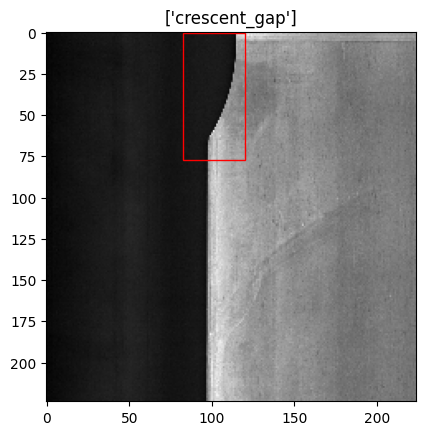

In [58]:
# Display a sample training image with its label
# Takes one batch from the train_dataset (which yields batches of images and labels).
for img, label in train_dataset.take(1):
    # show the first image in the batch. Convert the float pixel values in to PIL image that can be plotted
    plt.imshow(keras.preprocessing.image.array_to_img(img[0]))
    # Unpacks the label into its components (xmin tensor, ymin tensor, xmax tensor, ymax tensor, class one hot tensor
    out1, out2, out3, out4, out5 = label
    # Each outX is a batch of images so grap the first image and de-normalize the value from [0,1] back to [0,224]
    xmin, ymin, xmax, ymax = out1[0].numpy()*224, out2[0].numpy()*224, out3[0].numpy()*224, out4[0].numpy()*224
    # Creates a red rectangle object (bounding box) using matplotlib's Rectangle. 
    # The box is positioned at (xmin, ymin) with width/height derived from the bounding box coordinates.
    rect = Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin), fill = False, color = "r")
    # Gets the current axes object from matplotlib — needed to add custom shapes like rectangles.
    ax = plt.gca()
    # Adds the bounding box rectangle to the current image plot.
    ax.axes.add_patch(rect)
    # Creates a list to hold the predicted class label string for the image (though you're only adding one item here).
    pred_imglist = []
    # np.argmax(out5[0]) finds the index of the 1 in the one-hot vector (e.g., 2 if the class is 3).
    # +1 assumes your class labels start at 1 rather than 0.
    # class_dict[...] maps that numeric class ID to a human-readable string like "dent" or "scratch".
    pred_imglist.append(class_dict[np.argmax(out5[0])+1])
    plt.title(pred_imglist)
    plt.show()

In [59]:
# Import VGG16 model with pre-trained weights from ImageNet
# loads the VGG16 neural network, pre-trained on the ImageNet dataset, without its final classification layer (top), 
# and sets it up to accept images of shape 224×224 with 3 color channels (RGB).
# pooling='avg'. This turns the final convolutional feature maps into a single feature vector by averaging across the spatial dimensions.
# Output is a flat vector instead of a 3D feature map — which makes it easier to connect to a custom classification head later.
# This way, you can train your own classifier on top of VGG16’s powerful features, even with a smaller dataset.
#
# Summary: This code loads a pre-trained VGG16 model without the final classification layer, ready to be used as a feature extractor 
# for your own image classification or object detection task.
#base_vgg16 = tf.keras.applications.VGG16(weights = "imagenet", include_top = False, input_shape = (224,224,3), pooling = 'avg')

# Big Picture: What is this model doing?
# Imagine a robot with eyes (VGG16). You show it an image (e.g., of a metal part), and it:
# Figures out where a defect is — like drawing a red box around it (xmin, ymin, xmax, ymax)
# Decides what kind of defect it is — like saying “scratch” or “dent” (classification)
# So this model is doing two tasks at once:
# Object localization (bounding box regression)
# Object classification (what kind of thing is in the box)
# It's like a 3-part assembly line:
# [Image] → [Feature Extractor] → [Two Output Heads: Bounding Box + Class]

base_vgg16 = tf.keras.applications.VGG16(weights = 'data/misc/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top = False, input_shape = (224,224,3), pooling = 'avg')

In [60]:
# The robot is trainiable
base_vgg16.trainable = True

In [61]:
# Dear robot, expect each input to look like an image that’s 224x224 pixels with 3 color channels (RGB).
# (height, width, channels) = (224, 224, 3)
# In Keras Functional API, each time you pass a tensor through a layer, you're chaining a step in the computation graph. 
# That flow determines the model hierarchy.
# - input_layer_1
inputs = keras.Input(shape = (224,224,3))

In [62]:
# This will be a 1D feature vector — a kind of "summary" of what the model sees in the image.
# Robot, When a real image of shape (224, 224, 3) comes in, this is how it should flow through VGG16 to produce a 512-dimensional output.
# We're building a flowchart here (a graph of how data should move) not doing any real compution yet.
# - input_layer_1 --> vgg16
x = base_vgg16(inputs)
x.shape

(None, 512)

In [63]:
# Head #1: 
# Bounding Box (Where is the object?)
# Think of this as a machine that processes features into spatial understanding. 
# It transforms abstract visual features into more concrete location information.
# - input_layer_1 --> vgg16 --> dense (optionally name="dense")
# Create a layer object and pass the output of vgg16 (x) to it and return a new tensor value (x1)
x1 = keras.layers.Dense(1024, activation = "relu")(x) #dense
# - input_layer_1 --> vgg16 --> dense_1
# feed x1 into another dense layer a with 512 units and override x1 with the new output
x1 = keras.layers.Dense(512, activation = "relu")(x1) #dense_1

In [64]:
# The machine outputs four floating-point numbers, one for each corner of the bounding box — as if drawing a box around a defect.
# Where is the defect
# - input_layer_1 --> vgg16 --> dense_1 --> xmin
out1 = keras.layers.Dense(1, name = "xmin")(x1)
# - input_layer_1 --> vgg16 --> dense_1 --> ymin
out2 = keras.layers.Dense(1, name = "ymin")(x1)
# - input_layer_1 --> vgg16 --> dense_1 --> xmax
out3 = keras.layers.Dense(1, name = "xmax")(x1)
# - input_layer_1 --> vgg16 --> dense_1 --> ymax
out4 = keras.layers.Dense(1, name = "ymax")(x1)

In [65]:
# Head #2: 
# Classification (What is the defect?)
# This second machine takes the same visual input but tries to decide what it's looking at. 
# The Dropout is like forcing the model to generalize by hiding parts of what it sees — to avoid overconfidence.
# - input_layer_1 --> vgg16 --> dense_2
x2 = keras.layers.Dense(1024,activation = "relu")(x) #dense_2
x2 = keras.layers.Dropout(0.5)(x2)
x2 = keras.layers.Dense(512,activation = "relu")(x2) #dense_3
# This gives you a probability distribution over 10 classes — like saying: “There’s a 70% chance it’s a scratch, 20% it’s a dent, 10% inclusion.”
out_class = keras.layers.Dense(10,activation = "softmax", name = "class")(x2)

In [66]:
# Combine both outputs:
# You’re producing 5 outputs: 4 numbers for the bounding box 1 vector (length 10) for the class prediction
#   4 bounding box values: xmin, ymin, xmax, ymax → shape (None, 1)
#   1 classification output: class → shape (None, 10)
out = [out1, out2, out3, out4, out_class]

In [67]:
# This creates the full model and shows a summary of layers, shapes, and parameters.
vgg16 = keras.models.Model(inputs = inputs, outputs = out)
vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 512)               │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1024)              │         525,312 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1024)              │         525,312 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1024)              │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 512)               │         524,800 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 512)               │         524,800 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmin (Dense)                  │ (None, 1)                 │             513 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymin (Dense)                  │ (None, 1)                 │             513 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmax (Dense)                  │ (None, 1)                 │             513 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymax (Dense)                  │ (None, 1)                 │             513 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ class (Dense)                 │ (None, 10)                │           5,130 │ dense_3[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,822,094 (64.17 MB)

 Trainable params: 16,822,094 (64.17 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Layer: a single computational step in the model. It takes input data, performs some transformation, and passes the result to the next layer
#   input_layer_1: Placeholder for input image
#   vgg16: The pre-trained VGG16 feature extractor
#   dense_2: Fully connected layer with 1024 units
#   dropout: Randomly drops 50% of inputs during training
#   x/ymin, x/ymax, class: Final output heads

In [69]:
#                            +--------------------------+
#                            | input_layer_1 (Input)    |
#                            | shape: (224, 224, 3)     |
#                            +------------+-------------+
#                                         |
#                            +--------------------------+
#                            | vgg16 (Functional)       |
#                            | output shape: (512,)     |
#                            +------------+-------------+
#                                         |
#                    +----Bounding Box----+----Classification---+
#                    |                                          |
#                    x                                          x
#         +---------------------+                     +---------------------+
#         | dense (1024, relu)  |                     | dense_2 (1024, relu)|
#         +----------+----------+                     +----------+----------+
#                    |                                           |
#                    x1                                          x2
#         +---------------------+                     +---------------------+
#         | dense_1 (512, relu) |                     | dropout (rate=0.5)  |
#         +----------+----------+                     +----------+----------+
#                    |                                           |
#                    x1                                          x2
#         +-------+------+--------+                   +----------------------+
#         |       |       |       |                   | dense_3 (512, relu)  |
#         |       |       |       |                   +----------+-----------+
#         |       |       |       |                              |
#         x1      x1      x1      x1                             x2
#     +------+ +------+ +------+ +------+             +------------------------+
#     | xmin | | ymin | | xmax | | ymax |             | class (Dense, softmax) |
#     | (1)  | | (1)  | | (1)  | | (1)  |             | shape: (None, 10)      |
#     +------+ +------+ +------+ +------+             +-----------+------------+
#                                                                 |
#                                                                 x2
#                                                     +------------------------+
#                                                     |   10-class prediction  |
#                                                     +------------------------+

In [70]:
# Compile the model with optimizer and loss functions
# This code prepares your model for training by telling Keras:
# How to adjust the model’s weights (the optimizer)
# How to measure errors (the loss functions)
# What metrics to track during training (like accuracy and mean absolute error)
# Uses the Adam optimizer, a popular and efficient way of updating weights during training.
# The learning rate is set to 0.0005 — a relatively small step size for stable learning.
# loss = {
#        "xmin": "mse",
#        "ymin": "mse",
#        "xmax": "mse",
#        "ymax": "mse",
#        "class": "categorical_crossentropy"
# }
# This model has five outputs: xmin, ymin, xmax, ymax, and class
# Use Mean Squared Error (MSE) for the 4 bounding box outputs.  Good for continuous values like coordinates.
# Use Categorical Crossentropy for the class output. Standard for multi-class classification with one-hot encoded labels.
# metrics = ["mae", "acc"] 
#  "mae" = Mean Absolute Error (good for bounding boxes)
#  "acc" = Accuracy (used on the class output)
#######
#  “Hey Keras — use the Adam optimizer with a small learning rate. For the four bounding box outputs, 
#   use MSE to measure how far off the predictions are. For the class output, use categorical crossentropy. 
#   While training, also track how far off the boxes are on average (mae) and how often the predicted class is correct (acc).”
#######
vgg16.compile(keras.optimizers.Adam(0.0005),
   loss = { 
      "xmin": "mse",
      "ymin": "mse",
      "xmax": "mse",
      "ymax": "mse",
      "class": "categorical_crossentropy" 
   },
   metrics = {
      "xmin": "mae",
      "ymin": "mae",
      "xmax": "mae",
      "ymax": "mae",
      "class": "acc"
   }
)

In [71]:
# Reduce learning rate
# Creates a training callback that automatically adjusts (reduces) the learning rate if your model’s performance stops improving.
#    "val_loss"  : Monitors the validation loss (error on your validation set)
#    patience=5	 : Waits 5 epochs without improvement before taking action
#    factor=0.5	 : Reduces the learning rate by multiplying it by 0.5 (i.e., halves it)
#    min_lr=1e-6 : Ensures the learning rate never drops below 0.000001
lr_reduce = keras.callbacks.ReduceLROnPlateau("val_loss", patience = 5, factor = 0.5, min_lr = 1e-6)

In [72]:
# The below cell is primarily used for saving and loading meta data.  This allows us to train a model and save it
# so that we can run the script again and not have to go through the training which takes days.
# It's not enough to just save the keras data file. We save a bunch of associated meta data to help ensure that
# Nothing has changed since we last trained the model..

In [73]:
# --- Model/dataset metadata to ensure safe reuse of saved model ---
from pathlib import Path
import json, hashlib, os, glob

# Returns the names of the defect directories (crease, oil_spot, etc.)
def get_class_names_from_dirs(root_dir="data/images/images"):
    # Assumes GC10-DET is arranged as data/images/images/<class>/*.jpg (or png)
    if not os.path.isdir(root_dir):
        return []
    names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    names.sort()
    return names

# Creates a hash of the class name and number of instances (crease:52) so that we can verify none
# of the image files were deleted between training and reloading history.
def dataset_signature(root_dir="data/images/images"):
    # Produce a quick signature of dataset contents (class names + file counts)
    if not os.path.isdir(root_dir):
        return "missing"
    parts = []
    for cls in sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]):
        files = glob.glob(os.path.join(root_dir, cls, "*"))
        parts.append(f"{cls}:{len(files)}")
    digest = hashlib.sha1("|".join(parts).encode("utf-8")).hexdigest()
   
    return digest

def load_meta(path):
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def diff_meta(saved: dict, current: dict):
    """Return {key: (saved, current)} for keys that differ."""
    diffs, all_keys = {}, set((saved or {}).keys()) | set((current or {}).keys())
    for k in sorted(all_keys):
        if (saved or {}).get(k) != (current or {}).get(k):
            diffs[k] = ((saved or {}).get(k), (current or {}).get(k))
    return diffs

# --- Canonicalization helpers for robust meta comparison ---
def _norm_size(v):
    try:
        a, b = v
        return (int(a), int(b))  # always compare as a tuple of ints
    except Exception:
        return None

def _norm_class_names(v):
    try:
        return sorted(list(v))   # compare as a sorted list
    except Exception:
        return []

def _canon_meta(meta: dict, *, strict: bool, check_sig: bool):
    if meta is None:
        return None
    # Base keys always enforced
    keys = ["image_size", "num_classes", "class_names", "model_arch"]
    # Strict mode can include additional invariants you care about
    if strict:
        keys += ["preprocessing"]  # add more if you want iron-clad parity
    if check_sig:
        keys += ["dataset_sig"]

    canon = {}
    for k in keys:
        v = meta.get(k)

        if k == "image_size":
            v = _norm_size(v)
        elif k == "class_names":
            v = _norm_class_names(v)
        # everything else compared as-is
        canon[k] = v
    return canon

def meta_matches(saved: dict, current: dict) -> bool:
    if saved is None or current is None:
        return False
    s = _canon_meta(saved,   strict=META_STRICT, check_sig=CHECK_DATASET_SIG)
    c = _canon_meta(current, strict=META_STRICT, check_sig=CHECK_DATASET_SIG)
    return s == c

# (Optional) make saved JSON consistent going forward
def save_meta(meta: dict, path: Path):
    meta = dict(meta)
    # store image_size canonically as a list for JSON readability
    if isinstance(meta.get("image_size"), tuple):
        meta["image_size"] = list(meta["image_size"])
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, sort_keys=True)

# Derive current meta from filesystem & notebook assumptions
CURRENT_META = {
    "image_size": (224, 224),             # VGG16 input size (adjust if you changed it elsewhere)
    "class_names": get_class_names_from_dirs(),
    "num_classes": len(get_class_names_from_dirs()),
    "preprocessing": "rescale(1/255)",    # keep in sync with your pipeline
    "model_arch": "VGG16",
    "dataset_sig": dataset_signature(),
}


In [74]:
# Train the model
# This function runs the training loop for your custom VGG16-based model in Keras. 
# It's where your model finally sees the data and learns from it.
#     Training data: train_dataset
#     Validation data: test_dataset
#######
# This code trains the model for up to 200 epochs, using batches of data from train_dataset. 
# After each epoch, it evaluates on test_dataset. If validation loss stops improving for 5 epochs, 
# it reduces the learning rate to help refine learning. All training stats are stored in the history object.
# Returns History: keras.callbacks.History
#     history.history → a dict mapping metric names to lists of values, one entry per epoch.
#        Example: 'loss': [...], 'val_loss': [...], 'accuracy': [...], 'val_accuracy': [...], ...}
#     history.epoch → a list of epoch indices that actually ran.
#        Example: [0, 1, 2, ..., 199]
#######

In [75]:
def train_model(
    model,
    train_dataset,
    test_dataset,
    train_count: int,
    test_count: int,
    batch_size: int,
    *,
    epochs: int = 200,
    callbacks=None,
    verbose: int = 1,
):
    """
    Train a Keras model with standard steps/epoch math and return the History.

    Parameters
    ----------
    model : tf.keras.Model
        Your compiled model (e.g., vgg16).
    train_dataset, test_dataset : tf.data.Dataset
        Datasets yielding (x, y) batches.
    train_count, test_count : int
        Number of samples in train/validation sets.
    batch_size : int
        Batch size used to compute steps.
    epochs : int, default 200
        Max epochs.
    callbacks : list, optional
        Keras callbacks (e.g., [lr_reduce]).
    verbose : int, default 1
        Keras fit verbosity.

    Returns
    -------
    history : tf.keras.callbacks.History
    """
    if callbacks is None:
        callbacks = []

    steps_per_epoch = max(1, train_count // batch_size)
    validation_steps = max(1, test_count // batch_size)

    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_dataset,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=verbose,
    )
    return history


In [76]:
from pathlib import Path
from tensorflow import keras
import os

MODEL_PATH = VGG_MODEL_PATH
META_PATH  = MODEL_PATH.with_suffix(".meta.json")
CURRENT_META = make_current_meta("VGG16", (224, 224))
saved_meta = load_meta(VGG_META_PATH)
can_reuse = MODEL_PATH.exists() and meta_matches(saved_meta, CURRENT_META) and not FORCE_RETRAIN

if can_reuse:
    print(f"Metadata matched. Loading model from {MODEL_PATH} (compile=True).")
    vgg16 = keras.models.load_model(MODEL_PATH, compile=True)
else:
    if MODEL_PATH.exists() and not meta_matches(saved_meta, CURRENT_META):
        diffs = diff_meta(saved_meta, CURRENT_META)
        print("Saved model metadata does not match current dataset/config. Differences:")
        for k, (a, b) in diffs.items():
            print(f" - {k}: saved={a} current={b}")
    elif MODEL_PATH.exists() and FORCE_RETRAIN:
        print("FORCE_RETRAIN=True: retraining despite existing saved model...")
    else:
        print("No saved model found. Training from scratch...")
    # Train, then save model + metadata (and history if the helper exists)
    history_obj = train_model(
        vgg16,
        train_dataset,
        test_dataset,
        train_count=train_count,
        test_count=test_count,
        batch_size=batch_size,
        epochs=200,
        callbacks=[lr_reduce],   # keep your callbacks
    )
    vgg16.save(str(MODEL_PATH), include_optimizer=False)
    save_meta(CURRENT_META, META_PATH)
    save_history(
        history_obj,
        json_path=str(VGG_HISTORY_JSON),
        csv_path=str(VGG_HISTORY_CSV),
    )
    print(f"Model saved to {MODEL_PATH} and metadata to {META_PATH}")

Metadata matched. Loading model from data\model\vgg16\vgg16_model.keras (compile=True).


In [77]:
# Below is where we actually train the model but only if FORCE_RETRAIN is True.

In [78]:
# --- Plot previously saved training history (works even when skipping training) ---
# -- hist_df is a Pandas DataFrame
hist_df = load_history_df(
    json_path=str(VGG_HISTORY_JSON),
    csv_path=str(VGG_HISTORY_CSV),
)

In [79]:
# NOTE: Save moved into the load-or-train cell to ensure single save point.
# Original code commented out to avoid duplicate saves.
# vgg16.save("data/model/vgg16_model.keras")

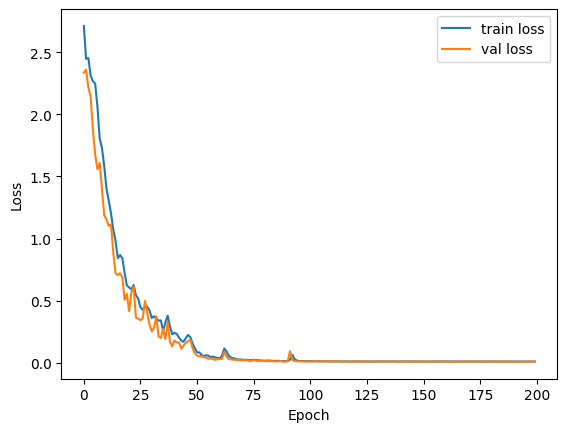

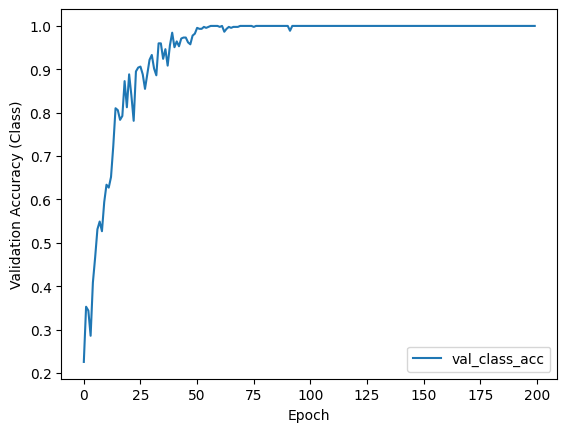

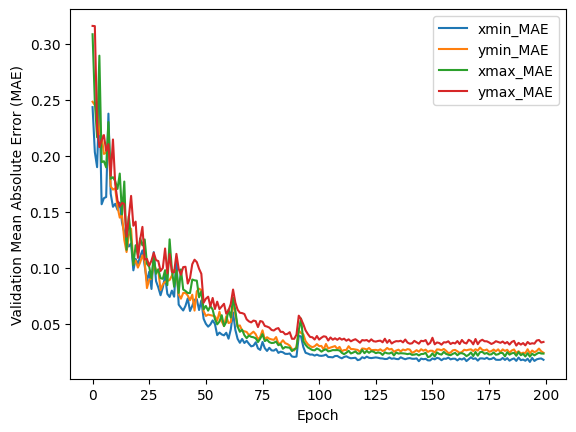

In [80]:
if hist_df is not None:
    plot_history_df(hist_df)

In [81]:
results = vgg16.evaluate(test_dataset, return_dict=True)

456/456 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - class_acc: 1.0000 - class_loss: 1.2179e-04 - loss: 0.0083 - xmax_loss: 0.0016 - xmax_mae: 0.0227 - xmin_loss: 0.0012 - xmin_mae: 0.0198 - ymax_loss: 0.0030 - ymax_mae: 0.0319 - ymin_loss: 0.0023 - ymin_mae: 0.0273


In [82]:
print("MAE of xmin value in test set:{}".format(results['xmin_mae']))
print("MAE of ymin value in test set:{}".format(results['ymin_mae']))
print("MAE of xmax value in test set:{}".format(results['xmax_mae']))
print("MAE of ymax value in test set:{}".format(results['ymax_mae']))
print("Testing accuracy of predicted label:{}".format(results['class_acc']))

MAE of xmin value in test set:0.02014971897006035
MAE of ymin value in test set:0.02781657874584198
MAE of xmax value in test set:0.022833140566945076
MAE of ymax value in test set:0.03225412219762802
Testing accuracy of predicted label:1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


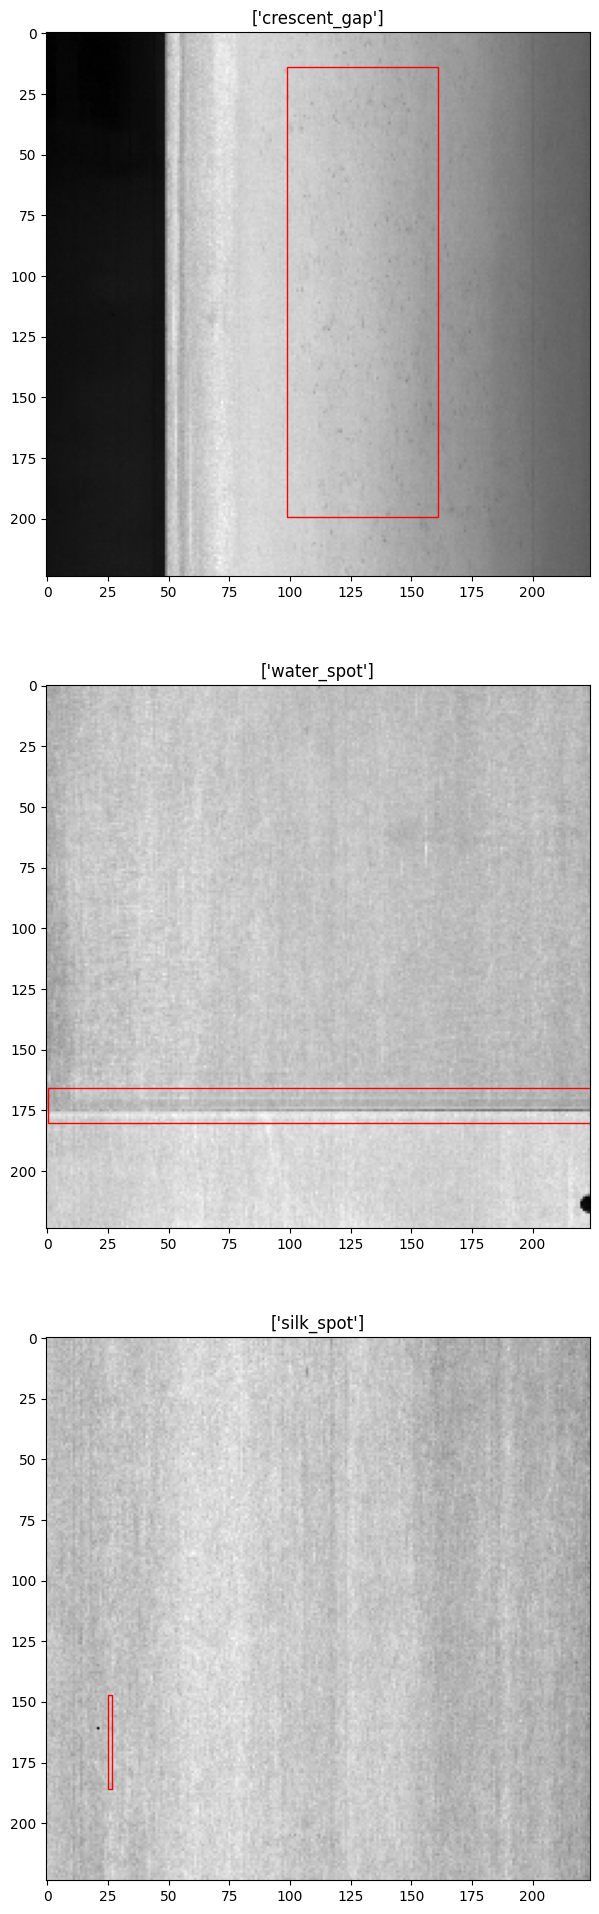

In [83]:
plt.figure(figsize = (10, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4, label = vgg16.predict(img)
    for i in range(3):
        plt.subplot(3, 1, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[i]) + 1])
        plt.title(pred_imglist)
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 
        ax = plt.gca()                   
        ax.axes.add_patch(rect)

In [84]:
# Append all the true labels into a list
true_labels = []
for _, label in test_dataset:    
    out1, out2, out3, out4, out5 = label                              
    true_labels.append(class_dict[np.argmax(out5) + 1])

In [85]:
true_labels

['water_spot',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'silk_spot',
 'silk_spot',
 'water_spot',
 'crescent_gap',
 'silk_spot',
 'silk_spot',
 'oil_spot',
 'welding_line',
 'water_spot',
 'water_spot',
 'water_spot',
 'punching_hole',
 'welding_line',
 'silk_spot',
 'welding_line',
 'inclusion',
 'oil_spot',
 'water_spot',
 'silk_spot',
 'water_spot',
 'oil_spot',
 'silk_spot',
 'welding_line',
 'crescent_gap',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'crescent_gap',
 'water_spot',
 'welding_line',
 'crescent_gap',
 'silk_spot',
 'water_spot',
 'inclusion',
 'silk_spot',
 'punching_hole',
 'punching_hole',
 'punching_hole',
 'crease',
 'inclusion',
 'oil_spot',
 'welding_line',
 'oil_spot',
 'inclusion',
 'oil_spot',
 'silk_spot',
 'crease',
 'silk_spot',
 'crescent_gap',
 'silk_spot',
 'silk_spot',
 'inclusion',
 'crescent_gap',
 'silk_spot',
 'crease',
 'water_spot',
 'welding_line',
 'silk_spot',
 'crescent_gap',
 'punching_hole',
 'silk_spot',
 'welding_line',
 'silk_spo

In [86]:
test_labels = []
for img, label in test_dataset:
    out1, out2, out3, out4, out5 = label
    label = vgg16.predict(img)
    test_labels.append(class_dict[np.argmax(out5) + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [87]:
test_labels

['crescent_gap',
 'silk_spot',
 'water_spot',
 'water_spot',
 'welding_line',
 'water_spot',
 'welding_line',
 'crescent_gap',
 'silk_spot',
 'punching_hole',
 'crescent_gap',
 'silk_spot',
 'silk_spot',
 'punching_hole',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'welding_line',
 'water_spot',
 'crease',
 'rolled_pit',
 'waist folding',
 'oil_spot',
 'silk_spot',
 'punching_hole',
 'water_spot',
 'oil_spot',
 'inclusion',
 'silk_spot',
 'inclusion',
 'water_spot',
 'crescent_gap',
 'waist folding',
 'silk_spot',
 'waist folding',
 'oil_spot',
 'welding_line',
 'punching_hole',
 'punching_hole',
 'punching_hole',
 'welding_line',
 'silk_spot',
 'waist folding',
 'waist folding',
 'oil_spot',
 'welding_line',
 'welding_line',
 'waist folding',
 'welding_line',
 'oil_spot',
 'welding_line',
 'welding_line',
 'waist folding',
 'oil_spot',
 'crescent_gap',
 'inclusion',
 'inclusion',
 'welding_line',
 'inclusion',
 'waist folding',
 'punching_hole',
 'silk_spot',
 'silk_sp

In [88]:
target_names = ['cresent_gap', 'crease', 'silk_spot', 'water_spot', 'welding_line', 
                'inclusion', 'oil_spot', 'waist_folding', 'rolled_pit', 'punching_hole']

In [89]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, test_labels, target_names = target_names))

               precision    recall  f1-score   support

  cresent_gap       0.00      0.00      0.00        15
       crease       0.17      0.17      0.17        47
    silk_spot       0.04      0.05      0.05        37
   water_spot       0.03      0.03      0.03        35
 welding_line       0.21      0.16      0.18        51
    inclusion       0.00      0.00      0.00         6
     oil_spot       0.25      0.26      0.25       124
waist_folding       0.11      0.14      0.12        22
   rolled_pit       0.16      0.15      0.16        65
punching_hole       0.08      0.07      0.08        54

     accuracy                           0.15       456
    macro avg       0.10      0.10      0.10       456
 weighted avg       0.15      0.15      0.15       456



In [90]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, test_labels, labels = target_names)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  2,  1,  2,  2,  0,  0,  1],
       [ 0,  1, 32, 19, 18,  9, 13,  0,  1, 13],
       [ 0,  2, 18, 10,  7,  8,  5,  0,  1,  4],
       [ 0,  2, 15,  9,  4,  2,  7,  0,  2,  4],
       [ 0,  5, 14,  4,  3,  2,  1,  0,  1,  2],
       [ 0,  1, 10,  4,  2,  3,  1,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  3,  0,  0,  0,  0],
       [ 0,  1, 18,  5,  4,  6,  1,  0,  0,  8]])

In [91]:
base_xception = tf.keras.applications.Xception(weights = "imagenet",
                                               include_top = False,
                                               input_shape = (224,224,3),
                                               pooling = 'avg')

In [92]:
# Train the base model with fully-connected layers
base_xception.trainable = True

In [93]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (224,224,3))
x = base_xception(inputs)

x1 = keras.layers.Dense(1024, activation = "relu")(x)
x1 = keras.layers.Dense(512, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(x1)

x2 = keras.layers.Dense(1024, activation = "relu")(x)
x2 = keras.layers.Dropout(0.5)(x2)
x2 = keras.layers.Dense(512, activation = "relu")(x2)
out_class = keras.layers.Dense(10, activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

xception = keras.models.Model(inputs = inputs, outputs = out)
xception.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xception (Functional)         │ (None, 2048)              │      20,861,480 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1024)              │       2,098,176 │ xception[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1024)              │       2,098,176 │ xception[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 1024)              │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 512)               │         524,800 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 512)               │         524,800 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmin (Dense)                  │ (None, 1)                 │             513 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymin (Dense)                  │ (None, 1)                 │             513 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmax (Dense)                  │ (None, 1)                 │             513 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymax (Dense)                  │ (None, 1)                 │             513 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ class (Dense)                 │ (None, 10)                │           5,130 │ dense_7[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 26,114,614 (99.62 MB)

 Trainable params: 26,060,086 (99.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [94]:
# Compile the model with optimizer and loss functions

xception.compile(keras.optimizers.Adam(0.0005),
   loss = { 
      "xmin" : "mse",
      "ymin" : "mse",
      "xmax" : "mse",
      "ymax" : "mse",
      "class": "categorical_crossentropy" 
   },
   metrics = {
      "xmin" : "mae",
      "ymin" : "mae",
      "xmax" : "mae",
      "ymax" : "mae",
      "class": "acc"
   }
)

In [95]:
MODEL_PATH = XCP_MODEL_PATH
CURRENT_META = make_current_meta("Xception", (224, 224))
META_PATH  = MODEL_PATH.with_suffix(".meta.json")
saved_meta = load_meta(XCP_META_PATH)
can_reuse = MODEL_PATH.exists() and meta_matches(saved_meta, CURRENT_META) and not FORCE_RETRAIN

if can_reuse:
    print(f"Loading Xception from {MODEL_PATH} (compile=True).")
    xception = keras.models.load_model(MODEL_PATH, compile=True)
    # Load last training curves for plotting
    hist_df = load_history_df(
        json_path=str(XCP_HISTORY_JSON),
        csv_path=str(XCP_HISTORY_CSV),
    )
else:
    print("Training Xception...")
    history = train_model(
        xception,
        train_dataset, test_dataset,
        train_count=train_count, test_count=test_count,
        batch_size=batch_size, epochs=200,
        callbacks=[lr_reduce],
    )
    xception.save(str(MODEL_PATH), include_optimizer=False)
    save_meta(CURRENT_META, META_PATH)

    # Persist curves next to the model
    save_history(
        history,
        json_path=str(XCP_HISTORY_JSON),
        csv_path=str(XCP_HISTORY_CSV),
    )
    # handy for immediate plotting
    hist_df = pd.DataFrame({**history.history, "epoch": list(history.epoch)})


Loading Xception from data\model\xception\xception_model.keras (compile=True).


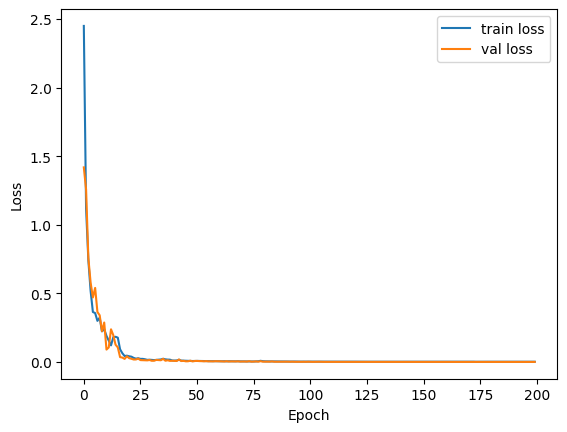

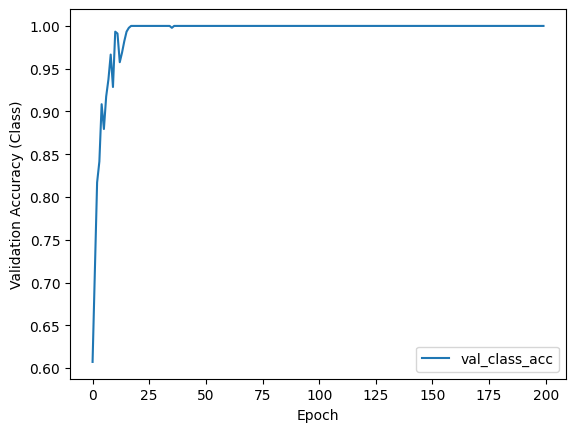

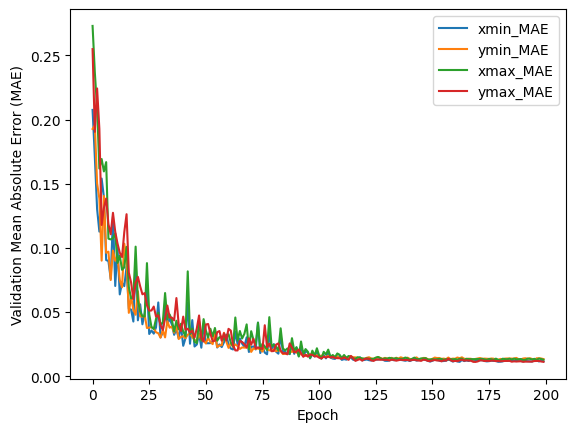

In [96]:
plot_history_df(hist_df)  

In [97]:
results = xception.evaluate(test_dataset, return_dict=True)

456/456 ━━━━━━━━━━━━━━━━━━━━ 590s 1s/step - class_acc: 1.0000 - class_loss: 1.2770e-06 - loss: 0.0011 - xmax_loss: 2.7254e-04 - xmax_mae: 0.0125 - xmin_loss: 2.3684e-04 - xmin_mae: 0.0114 - ymax_loss: 2.7655e-04 - ymax_mae: 0.0124 - ymin_loss: 3.0168e-04 - ymin_mae: 0.0125


In [98]:
print("MAE of xmin value in test set:{}".format(results['xmin_mae']))
print("MAE of ymin value in test set:{}".format(results['ymin_mae']))
print("MAE of xmax value in test set:{}".format(results['xmax_mae']))
print("MAE of ymax value in test set:{}".format(results['ymax_mae']))
print("Testing accuracy of predicted label:{}".format(results['class_acc']))

MAE of xmin value in test set:0.011298057623207569
MAE of ymin value in test set:0.012444526888430119
MAE of xmax value in test set:0.012399529106914997
MAE of ymax value in test set:0.012445725500583649
Testing accuracy of predicted label:1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


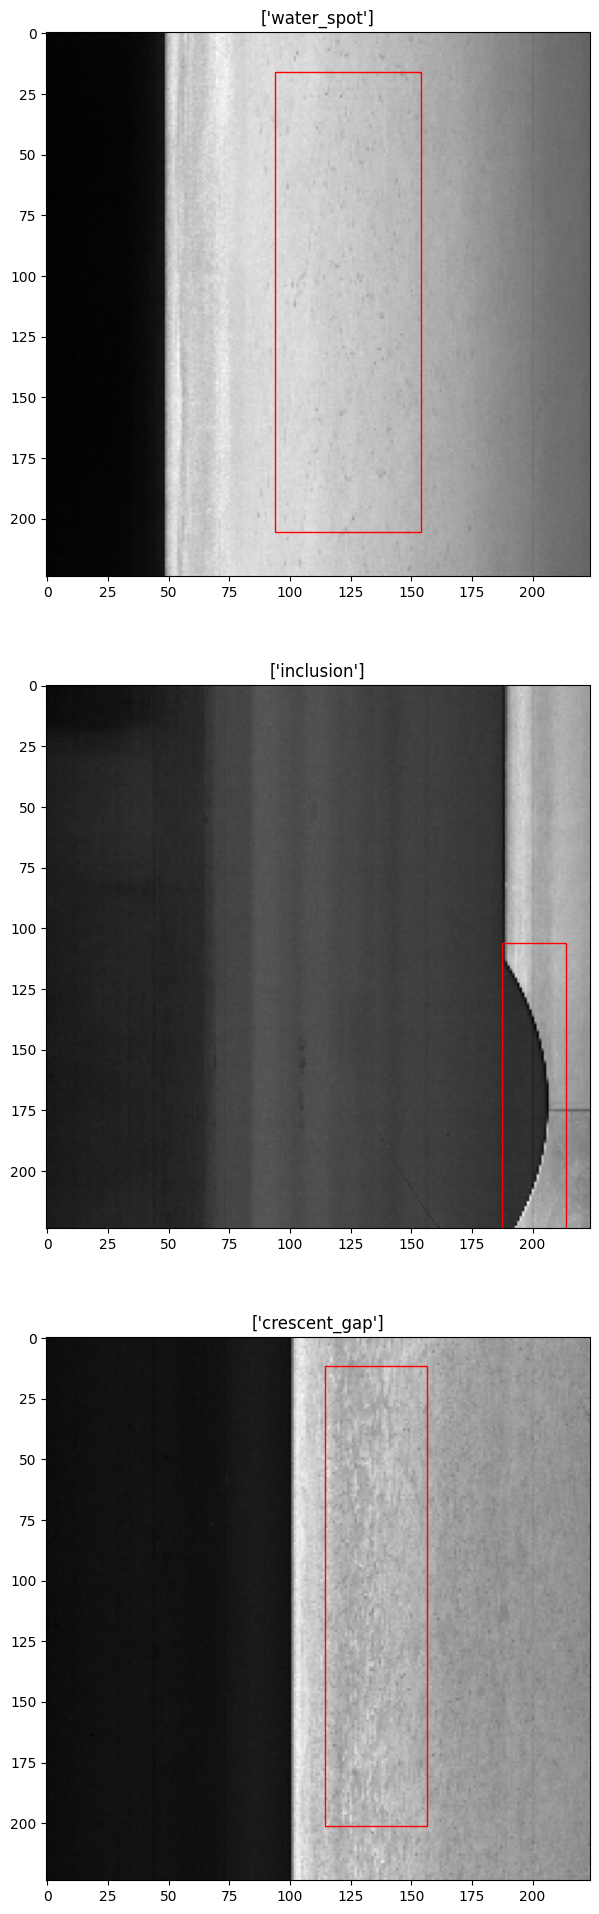

In [99]:
plt.figure(figsize = (10, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4, label = xception.predict(img)
    for i in range(3):
        plt.subplot(3, 1, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[i]) + 1])
        plt.title(pred_imglist)
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 
        ax = plt.gca()                   
        ax.axes.add_patch(rect)

In [100]:
test_labels = []

for img, label in test_dataset:
    out1, out2, out3, out4, out5 = label
    label = xception.predict(img)
    test_labels.append(class_dict[np.argmax(out5) + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [101]:
test_labels

['crease',
 'water_spot',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'silk_spot',
 'welding_line',
 'inclusion',
 'inclusion',
 'oil_spot',
 'water_spot',
 'inclusion',
 'water_spot',
 'silk_spot',
 'water_spot',
 'crescent_gap',
 'crescent_gap',
 'welding_line',
 'water_spot',
 'water_spot',
 'oil_spot',
 'silk_spot',
 'water_spot',
 'silk_spot',
 'inclusion',
 'welding_line',
 'punching_hole',
 'silk_spot',
 'water_spot',
 'oil_spot',
 'inclusion',
 'oil_spot',
 'water_spot',
 'punching_hole',
 'crescent_gap',
 'inclusion',
 'inclusion',
 'oil_spot',
 'waist folding',
 'oil_spot',
 'welding_line',
 'water_spot',
 'silk_spot',
 'silk_spot',
 'inclusion',
 'silk_spot',
 'water_spot',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'water_spot',
 'oil_spot',
 'silk_spot',
 'waist folding',
 'crescent_gap',
 'silk_spot',
 'crease',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'crescent_gap',
 'silk_spot',
 'silk_spot',
 'water_spot',
 'welding_line',
 'silk_spo

In [102]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, test_labels, target_names = target_names))

               precision    recall  f1-score   support

  cresent_gap       0.00      0.00      0.00        15
       crease       0.14      0.13      0.13        47
    silk_spot       0.10      0.11      0.10        37
   water_spot       0.04      0.06      0.05        35
 welding_line       0.06      0.04      0.05        51
    inclusion       0.00      0.00      0.00         6
     oil_spot       0.26      0.27      0.27       124
waist_folding       0.13      0.18      0.15        22
   rolled_pit       0.18      0.18      0.18        65
punching_hole       0.13      0.13      0.13        54

     accuracy                           0.16       456
    macro avg       0.10      0.11      0.11       456
 weighted avg       0.15      0.16      0.15       456



In [103]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, test_labels, labels = target_names)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  6,  4,  1,  2,  0,  0,  0,  0],
       [ 0,  1, 34, 20, 14, 11, 11,  0,  0, 11],
       [ 0,  2, 16, 12, 11,  6,  6,  0,  2,  3],
       [ 0,  0, 13,  5,  7,  8, 10,  0,  0,  4],
       [ 0,  1, 10,  6,  6,  4,  2,  0,  1,  1],
       [ 0,  0, 11,  4,  2,  4,  2,  0,  0,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  1,  2,  0,  0,  0,  0,  0],
       [ 0,  0, 16, 10,  4,  3,  7,  0,  0,  2]])

In [104]:
# Import InceptionResNetV2 model with pre-trained weights from ImageNet

base_inceptionresnetv2 = tf.keras.applications.InceptionResNetV2(weights = "imagenet",
                                                                 include_top = False,
                                                                 input_shape = (224,224,3),
                                                                 pooling = 'avg')

In [105]:
# Train the base model with fully-connected layers

base_inceptionresnetv2.trainable = True

In [106]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (224,224,3))
x = base_inceptionresnetv2(inputs)

x1 = keras.layers.Dense(1024, activation = "relu")(x)
x1 = keras.layers.Dense(512, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(x1)

x2 = keras.layers.Dense(1024, activation = "relu")(x)
x2 = keras.layers.Dropout(0.5)(x2)
x2 = keras.layers.Dense(512, activation = "relu")(x2)
out_class = keras.layers.Dense(10, activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

inceptionresnetv2 = keras.models.Model(inputs = inputs, outputs = out)
inceptionresnetv2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ inception_resnet_v2           │ (None, 1536)              │      54,336,736 │ input_layer_5[0][0]        │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 1024)              │       1,573,888 │ inception_resnet_v2[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 1024)              │       1,573,888 │ inception_resnet_v2[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 1024)              │               0 │ dense_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 512)               │         524,800 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 512)               │         524,800 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmin (Dense)                  │ (None, 1)                 │             513 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymin (Dense)                  │ (None, 1)                 │             513 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmax (Dense)                  │ (None, 1)                 │             513 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymax (Dense)                  │ (None, 1)                 │             513 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ class (Dense)                 │ (None, 10)                │           5,130 │ dense_11[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 58,541,294 (223.32 MB)

 Trainable params: 58,480,750 (223.09 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [107]:
inceptionresnetv2.compile(keras.optimizers.Adam(0.0005),
   loss = { 
      "xmin" : "mse",
      "ymin" : "mse",
      "xmax" : "mse",
      "ymax" : "mse",
      "class": "categorical_crossentropy" 
   },
   metrics = {
      "xmin" : "mae",
      "ymin" : "mae",
      "xmax" : "mae",
      "ymax" : "mae",
      "class": "acc"
   }
)

In [108]:
MODEL_PATH = ICP_MODEL_PATH
CURRENT_META = make_current_meta("Inception", (224, 224))
META_PATH  = MODEL_PATH.with_suffix(".meta.json")
saved_meta = load_meta(ICP_META_PATH)
can_reuse = MODEL_PATH.exists() and meta_matches(saved_meta, CURRENT_META) and not FORCE_RETRAIN

if can_reuse:
    print(f"Loading Inception from {MODEL_PATH} (compile=True).")
    inceptionresnetv2 = keras.models.load_model(MODEL_PATH, compile=True)
    # Load last training curves for plotting
    hist_df = load_history_df(
        json_path=str(ICP_HISTORY_JSON),
        csv_path=str(ICP_HISTORY_CSV),
    )
else:
    print("Training Inception...")
    history = train_model(
        inceptionresnetv2,
        train_dataset, test_dataset,
        train_count=train_count, test_count=test_count,
        batch_size=batch_size, epochs=200,
        callbacks=[lr_reduce],
    )
    inceptionresnetv2.save(str(MODEL_PATH), include_optimizer=False)
    save_meta(CURRENT_META, META_PATH)

    # Persist curves next to the model
    save_history(
        history,
        json_path=str(ICP_HISTORY_JSON),
        csv_path=str(ICP_HISTORY_CSV),
    )
    # handy for immediate plotting
    hist_df = pd.DataFrame({**history.history, "epoch": list(history.epoch)})

Loading Inception from data\model\inception\inception_model.keras (compile=True).


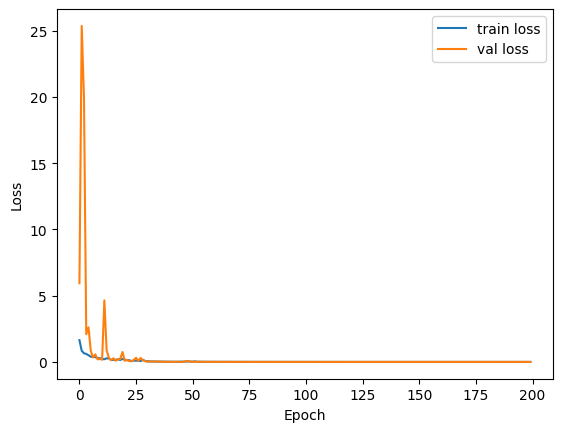

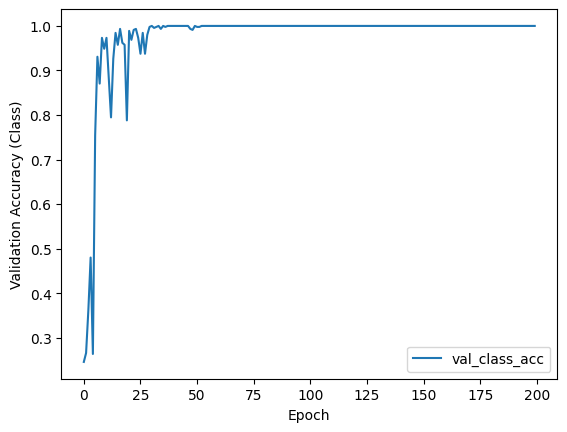

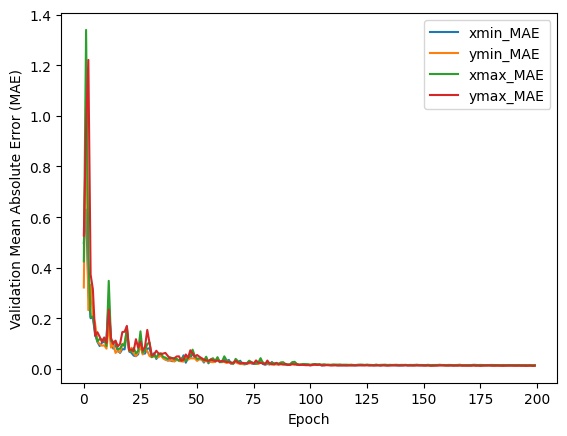

In [109]:
plot_history_df(hist_df) 

In [110]:
results = inceptionresnetv2.evaluate(test_dataset, return_dict=True)

456/456 ━━━━━━━━━━━━━━━━━━━━ 618s 1s/step - class_acc: 1.0000 - class_loss: 3.0564e-06 - loss: 0.0014 - xmax_loss: 3.7013e-04 - xmax_mae: 0.0144 - xmin_loss: 3.1988e-04 - xmin_mae: 0.0132 - ymax_loss: 2.9934e-04 - ymax_mae: 0.0132 - ymin_loss: 3.7457e-04 - ymin_mae: 0.0141


In [111]:
print("MAE of xmin value in test set:{}".format(results['xmin_mae']))
print("MAE of ymin value in test set:{}".format(results['ymin_mae']))
print("MAE of xmax value in test set:{}".format(results['xmax_mae']))
print("MAE of ymax value in test set:{}".format(results['ymax_mae']))
print("Testing accuracy of predicted label:{}".format(results['class_acc']))

MAE of xmin value in test set:0.013093073852360249
MAE of ymin value in test set:0.014060191810131073
MAE of xmax value in test set:0.014361025765538216
MAE of ymax value in test set:0.013230958953499794
Testing accuracy of predicted label:1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


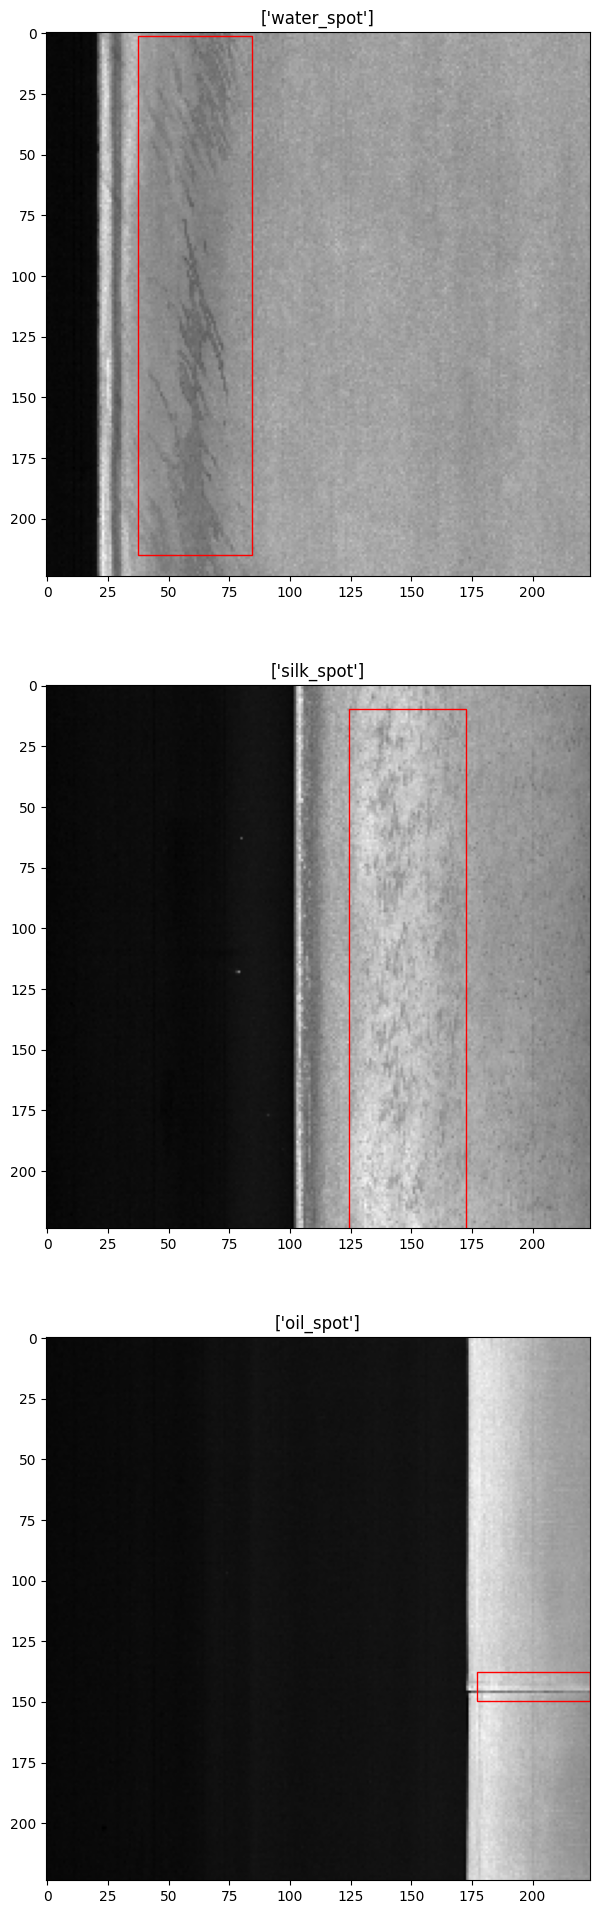

In [112]:
plt.figure(figsize = (10, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4, label = inceptionresnetv2.predict(img)
    for i in range(3):
        plt.subplot(3, 1, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[i]) + 1])
        plt.title(pred_imglist)
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 
        ax = plt.gca()                   
        ax.axes.add_patch(rect)

In [113]:
test_labels = []

for img, label in test_dataset:
    out1, out2, out3, out4, out5 = label
    label = inceptionresnetv2.predict(img)
    test_labels.append(class_dict[np.argmax(out5) + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [114]:
test_labels

['silk_spot',
 'welding_line',
 'water_spot',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'oil_spot',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'oil_spot',
 'inclusion',
 'water_spot',
 'waist folding',
 'silk_spot',
 'punching_hole',
 'welding_line',
 'inclusion',
 'water_spot',
 'crescent_gap',
 'silk_spot',
 'welding_line',
 'oil_spot',
 'inclusion',
 'oil_spot',
 'inclusion',
 'silk_spot',
 'crescent_gap',
 'silk_spot',
 'crescent_gap',
 'crescent_gap',
 'silk_spot',
 'inclusion',
 'crescent_gap',
 'silk_spot',
 'punching_hole',
 'oil_spot',
 'silk_spot',
 'punching_hole',
 'silk_spot',
 'punching_hole',
 'welding_line',
 'crease',
 'crescent_gap',
 'waist folding',
 'inclusion',
 'inclusion',
 'waist folding',
 'punching_hole',
 'silk_spot',
 'welding_line',
 'silk_spot',
 'welding_line',
 'welding_line',
 'welding_line',
 'inclusion',
 'silk_spot',
 'silk_spot',
 'inclusion',
 'crescent_gap',
 'silk_spot',
 'oil_spot',
 'silk_spot',
 'waist folding',
 'welding_li

In [115]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, test_labels, target_names = target_names))

               precision    recall  f1-score   support

  cresent_gap       0.09      0.07      0.08        15
       crease       0.10      0.11      0.11        47
    silk_spot       0.05      0.05      0.05        37
   water_spot       0.03      0.03      0.03        35
 welding_line       0.14      0.10      0.12        51
    inclusion       0.00      0.00      0.00         6
     oil_spot       0.34      0.37      0.35       124
waist_folding       0.03      0.05      0.04        22
   rolled_pit       0.25      0.22      0.23        65
punching_hole       0.20      0.20      0.20        54

     accuracy                           0.19       456
    macro avg       0.12      0.12      0.12       456
 weighted avg       0.19      0.19      0.19       456



In [116]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, test_labels, labels = target_names)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  5,  1,  3,  1,  0,  0,  1,  0],
       [ 0,  3, 46, 16, 16, 10,  6,  0,  2,  6],
       [ 0,  1, 19, 14,  3,  7,  7,  0,  0,  6],
       [ 0,  1,  8,  4, 11,  4,  7,  0,  0,  5],
       [ 0,  1, 11,  3,  5,  2,  1,  0,  1,  4],
       [ 0,  1,  7,  4,  5,  4,  1,  0,  1,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0,  0],
       [ 0,  2, 16,  6,  5,  4,  4,  0,  0,  5]])

In [117]:
# Import InceptionResNetV2 model with pre-trained weights from ImageNet

base_resnet152v2 = tf.keras.applications.ResNet152V2(weights = "imagenet",
                                                     include_top = False,
                                                     input_shape = (224,224,3),
                                                     pooling = 'avg')

In [118]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (224,224,3))
x = base_resnet152v2(inputs)

x1 = keras.layers.Dense(1024, activation = "relu")(x)
x1 = keras.layers.Dense(512, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(x1)

x2 = keras.layers.Dense(1024, activation = "relu")(x)
x2 = keras.layers.Dropout(0.5)(x2)
x2 = keras.layers.Dense(512, activation = "relu")(x2)
out_class = keras.layers.Dense(10, activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

resnet152v2 = keras.models.Model(inputs = inputs, outputs = out)
resnet152v2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet152v2 (Functional)      │ (None, 2048)              │      58,331,648 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 1024)              │       2,098,176 │ resnet152v2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 1024)              │       2,098,176 │ resnet152v2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 1024)              │               0 │ dense_14[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 512)               │         524,800 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 512)               │         524,800 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmin (Dense)                  │ (None, 1)                 │             513 │ dense_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymin (Dense)                  │ (None, 1)                 │             513 │ dense_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xmax (Dense)                  │ (None, 1)                 │             513 │ dense_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ymax (Dense)                  │ (None, 1)                 │             513 │ dense_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ class (Dense)                 │ (None, 10)                │           5,130 │ dense_15[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 63,584,782 (242.56 MB)

 Trainable params: 63,441,038 (242.01 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [119]:
resnet152v2.compile(keras.optimizers.Adam(0.0005),
   loss = { 
      "xmin" : "mse",
      "ymin" : "mse",
      "xmax" : "mse",
      "ymax" : "mse",
      "class": "categorical_crossentropy" 
   },
   metrics = {
      "xmin" : "mae",
      "ymin" : "mae",
      "xmax" : "mae",
      "ymax" : "mae",
      "class": "acc"
   }
)

In [120]:
# --- resnet152v2 ---
RES_MODEL_PATH = Path("data/model/resnet152v2/resnet152v2_model.keras")
RES_MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
RES_META_PATH  = RES_MODEL_PATH.with_suffix(".meta.json")
RES_HISTORY_JSON = Path("data/model/resnet152v2/resnet152v2_history.json")
RES_HISTORY_CSV  = RES_HISTORY_JSON.with_suffix(".csv")

MODEL_PATH = RES_MODEL_PATH
CURRENT_META = make_current_meta("resnet152v2", (224, 224))
META_PATH  = MODEL_PATH.with_suffix(".meta.json")
saved_meta = load_meta(RES_META_PATH)
can_reuse = MODEL_PATH.exists() and meta_matches(saved_meta, CURRENT_META) and not FORCE_RETRAIN

if can_reuse:
    print(f"Loading resnet152v2 from {MODEL_PATH} (compile=True).")
    resnet152v2 = keras.models.load_model(MODEL_PATH, compile=True)
    # Load last training curves for plotting
    hist_df = load_history_df(
        json_path=str(RES_HISTORY_JSON),
        csv_path=str(RES_HISTORY_CSV),
    )
else:
    print("Training resnet152v2...")
    history = train_model(
        resnet152v2,
        train_dataset, test_dataset,
        train_count=train_count, test_count=test_count,
        batch_size=batch_size, epochs=200,
        callbacks=[lr_reduce],
    )
    resnet152v2.save(str(MODEL_PATH), include_optimizer=False)
    save_meta(CURRENT_META, META_PATH)

    # Persist curves next to the model
    save_history(
        history,
        json_path=str(RES_HISTORY_JSON),
        csv_path=str(RES_HISTORY_CSV),
    )
    # handy for immediate plotting
    hist_df = pd.DataFrame({**history.history, "epoch": list(history.epoch)})

Loading resnet152v2 from data\model\resnet152v2\resnet152v2_model.keras (compile=True).


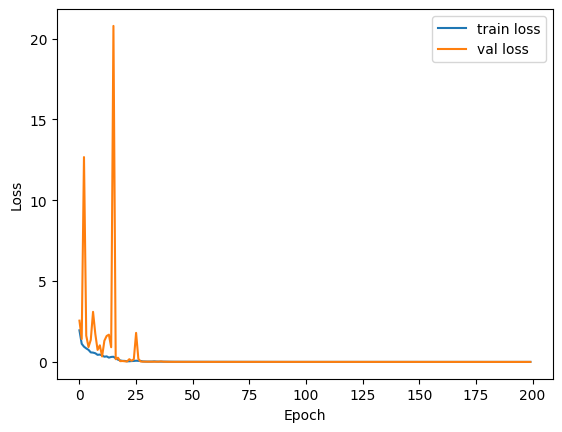

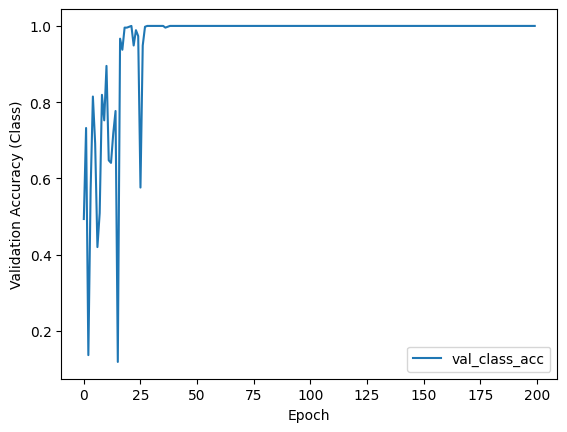

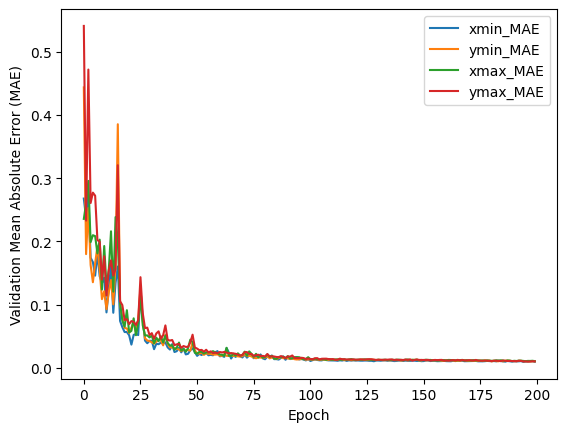

In [121]:
plot_history_df(hist_df)

In [122]:
results = resnet152v2.evaluate(test_dataset, return_dict=True)

456/456 ━━━━━━━━━━━━━━━━━━━━ 1004s 2s/step - class_acc: 1.0000 - class_loss: 4.8489e-06 - loss: 7.8302e-04 - xmax_loss: 1.8993e-04 - xmax_mae: 0.0107 - xmin_loss: 1.8215e-04 - xmin_mae: 0.0101 - ymax_loss: 2.2183e-04 - ymax_mae: 0.0113 - ymin_loss: 1.8426e-04 - ymin_mae: 0.0103


In [123]:
print("MAE of xmin value in test set:{}".format(results['xmin_mae']))
print("MAE of ymin value in test set:{}".format(results['ymin_mae']))
print("MAE of xmax value in test set:{}".format(results['xmax_mae']))
print("MAE of ymax value in test set:{}".format(results['ymax_mae']))
print("Testing accuracy of predicted label:{}".format(results['class_acc']))

MAE of xmin value in test set:0.010205375961959362
MAE of ymin value in test set:0.010356713086366653
MAE of xmax value in test set:0.010651983320713043
MAE of ymax value in test set:0.011372466571629047
Testing accuracy of predicted label:1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


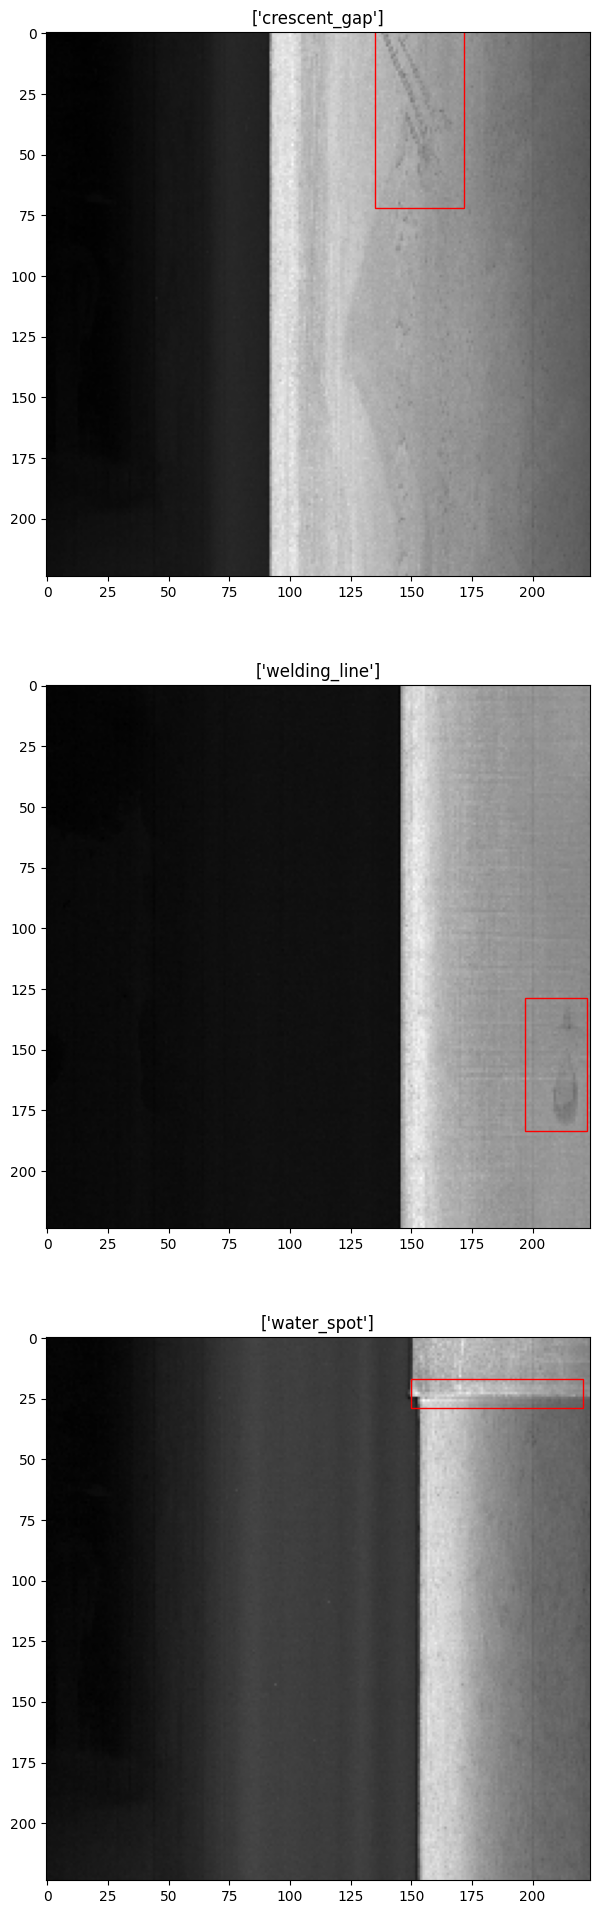

In [124]:
plt.figure(figsize = (10, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4, label = resnet152v2.predict(img)
    for i in range(3):
        plt.subplot(3, 1, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[i]) + 1])
        plt.title(pred_imglist)
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 
        ax = plt.gca()                   
        ax.axes.add_patch(rect)

In [125]:
test_labels = []
for img, label in test_dataset:
    out1, out2, out3, out4, out5 = label
    label = resnet152v2.predict(img)
    test_labels.append(class_dict[np.argmax(out5) + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [126]:
test_labels

['water_spot',
 'water_spot',
 'silk_spot',
 'water_spot',
 'welding_line',
 'inclusion',
 'water_spot',
 'oil_spot',
 'water_spot',
 'silk_spot',
 'silk_spot',
 'water_spot',
 'welding_line',
 'silk_spot',
 'inclusion',
 'punching_hole',
 'crescent_gap',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'welding_line',
 'welding_line',
 'water_spot',
 'punching_hole',
 'rolled_pit',
 'oil_spot',
 'inclusion',
 'silk_spot',
 'water_spot',
 'water_spot',
 'silk_spot',
 'punching_hole',
 'water_spot',
 'inclusion',
 'silk_spot',
 'waist folding',
 'crescent_gap',
 'punching_hole',
 'waist folding',
 'silk_spot',
 'punching_hole',
 'welding_line',
 'oil_spot',
 'inclusion',
 'oil_spot',
 'waist folding',
 'welding_line',
 'waist folding',
 'welding_line',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'crescent_gap',
 'waist folding',
 'inclusion',
 'punching_hole',
 'crescent_gap',
 'water_spot',
 'crescent_gap',
 'silk_spot',
 'crescent_gap',
 'oil_spot',
 'waist folding',
 'silk_spot',
 'silk_

In [127]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, test_labels, target_names = target_names))

               precision    recall  f1-score   support

  cresent_gap       0.00      0.00      0.00        15
       crease       0.14      0.15      0.14        47
    silk_spot       0.04      0.05      0.05        37
   water_spot       0.03      0.03      0.03        35
 welding_line       0.13      0.14      0.13        51
    inclusion       0.00      0.00      0.00         6
     oil_spot       0.31      0.35      0.33       124
waist_folding       0.05      0.05      0.05        22
   rolled_pit       0.24      0.20      0.22        65
punching_hole       0.05      0.04      0.04        54

     accuracy                           0.17       456
    macro avg       0.10      0.10      0.10       456
 weighted avg       0.16      0.17      0.16       456



In [128]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_labels, test_labels, labels = target_names)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  2,  2,  0,  2,  0,  0,  2],
       [ 0,  1, 43, 15,  9, 11,  8,  0,  1, 13],
       [ 0,  1, 18, 13,  7, 12,  2,  0,  3,  5],
       [ 0,  3, 15,  6,  2,  7,  5,  0,  1,  6],
       [ 0,  1, 13,  3,  3,  2,  5,  0,  0,  6],
       [ 0,  0,  7,  4,  6,  2,  1,  0,  2,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  2,  0,  0,  0,  2],
       [ 0,  1, 18,  7,  7,  3,  2,  0,  0,  7]])